# Stock Prediction Model

## Dependencies

### Library Installation (if needed)

In [1]:
#! pip install -Ur requirements.txt

### Importing Required Libraries

In [2]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
import pickle
import gradio as gr
import ast
import warnings
from datetime import datetime
from tqdm import tqdm
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

### Variables

In [3]:
warnings.filterwarnings("ignore", category=FutureWarning)
symbol_list = input("Symbols: ('simple', 'filtered' or 'all')") # 'simple' or 'all'. simple are the tickers from the screener notebook and all are all of the tickers in 'filtered_tickers'. You may also an 'Int' to get a % amount of random tickers from 'all'
if symbol_list:
    build_new_dataset = True
else:
    build_new_dataset = False
    symbol_list = 'filtered'
minimum_feature_threshold = 0.6
hidden_layers = ast.literal_eval(f"({input('Hidden Layers: eg. "100, 100"')})")
if hidden_layers:
    train_new_model = True
    verticle_jobs = 1 #'-1' for max
if build_new_dataset or train_new_model:
    debugging = {'True': True, 'False': False}.get(input('Debug? (Bool)'))
else:
    debugging = False

## Data Preparation

In [4]:
symbols = pd.read_csv('../data/simple_tickers.csv')['Ticker'].tolist()
if symbol_list == 'filtered':
    symbols = symbols + pd.read_csv('../data/filtered_tickers.csv')['Ticker'].tolist()
elif symbol_list == 'all':
    symbols = symbols + pd.read_csv('../data/tickers.csv')['Ticker'].tolist()
elif symbol_list.isdigit():
    all_symbols = pd.read_csv('../data/tickers.csv')['Ticker'].tolist()
    num_symbols = max(1, round(len(all_symbols) * (int(symbol_list) / 100)))  
    symbols = symbols + pd.read_csv("../data/filtered_tickers.csv")["Ticker"].tolist()
    symbols = symbols + np.random.choice(all_symbols, num_symbols, replace=False).tolist()

symbols = pd.Series(symbols).unique()
symbols

array(['MATAS.CO', 'TRIFOR.CO', 'RNMBY', ..., 'WEN', 'YORW', 'ZION'],
      dtype=object)

#### Download annual financial data

In [5]:
if build_new_dataset:
    df = pd.DataFrame()
    filtered_pd = pd.read_csv('../data/filtered_tickers.csv')
    for symbol in tqdm(symbols, smoothing=0):
        ticker_df = pd.DataFrame()
        ticker = yf.Ticker(symbol)
        try:
            # Latest earning data
            latest_earning_date = ticker.quarterly_cash_flow.columns.tolist()[0]
            latest_data = {'Ticker': symbol, 'Name': ticker.info["shortName"], 'Date': latest_earning_date}
            latest_data['3M Future Change'] = np.nan
            latest_data['6M Future Change'] = np.nan
            latest_data['9M Future Change'] = np.nan
            latest_data['1Y Future Change'] = np.nan
            try:
                latest_data['Sector'] = ticker.info['sector']
            except:
                latest_data['Sector'] = 'Unknown'
            try:
                latest_data['Industry'] = ticker.info['industry']
            except:
                latest_data['Industry'] = 'Unknown'
            for column in ticker.quarterly_cash_flow[latest_earning_date].keys().tolist():
                latest_data[column] = ticker.quarterly_cash_flow[latest_earning_date][column]
            for column in ticker.quarterly_balance_sheet[latest_earning_date].keys().tolist():
                latest_data[column] = ticker.quarterly_balance_sheet[latest_earning_date][column]
            for column in ticker.quarterly_income_stmt[latest_earning_date].keys().tolist():
                latest_data[column] = ticker.quarterly_income_stmt[latest_earning_date][column]
            ticker_df = pd.concat([ticker_df, pd.DataFrame([latest_data])], ignore_index=True)

            # Annual data
            earning_dates = ticker.cash_flow.columns.tolist()
            if len(earning_dates) == 5:
                earning_dates.remove(earning_dates[4])
            else:
                if symbol in filtered_pd['Ticker'].tolist():
                    filtered_pd = filtered_pd[filtered_pd['Ticker'] != symbol]
                if debugging:
                    print(f"{symbol} had {len(earning_dates)} earning dates, not 5")
                continue
            price_data = yf.download(symbol, period='5y', rounding=False, progress=False)
            cash_flow = ticker.cash_flow
            cash_flow_columns = cash_flow[earning_dates[0]].keys().tolist()
            balance_sheet = ticker.balance_sheet
            balance_sheet_columns = balance_sheet[earning_dates[0]].keys().tolist()
            income_statement = ticker.income_stmt
            income_statement_columns = income_statement[earning_dates[0]].keys().tolist()
            for earning_date in earning_dates:
                earning_date_data = {'Ticker': symbol, 'Name': ticker.info["shortName"], 'Date': earning_date}
                got_price = False
                day_offset = 0
                while(got_price==False and day_offset > -6):
                    try:           
                        earning_date_data['3M Future Change'] = (
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset, weeks=13) , ('Close', symbol)]) / 
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset), ('Close', symbol)]) - 1
                        )
                        earning_date_data['6M Future Change'] = (
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset, weeks=26) , ('Close', symbol)]) / 
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset), ('Close', symbol)]) - 1
                        )
                        earning_date_data['9M Future Change'] = (
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset, weeks=39) , ('Close', symbol)]) / 
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset), ('Close', symbol)]) - 1
                        )
                        earning_date_data['1Y Future Change'] = (
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset, weeks=52) , ('Close', symbol)]) / 
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset), ('Close', symbol)]) - 1
                        )
                        got_price = True
                    except:
                        day_offset += -1
                try:
                    earning_date_data['Sector'] = ticker.info['sector']
                except:
                    earning_date_data['Sector'] = 'Unknown'
                try:
                    earning_date_data['Industry'] = ticker.info['industry']
                except:
                    earning_date_data['Industry'] = 'Unknown'
                for column in cash_flow_columns:
                    earning_date_data[column] = cash_flow[earning_date][column]
                for column in balance_sheet_columns:
                    earning_date_data[column] = balance_sheet[earning_date][column]
                for column in income_statement_columns:
                    earning_date_data[column] = income_statement[earning_date][column]
                if got_price:
                    ticker_df = pd.concat([ticker_df, pd.DataFrame([earning_date_data])], ignore_index=True)
            
            if len(ticker_df) != 4:
                if symbol in filtered_pd['Ticker'].tolist():
                    filtered_pd = filtered_pd[filtered_pd['Ticker'] != symbol]
                    if debugging:
                        print(f'Removed {symbol} from filtered tickers because the length of the df was not 4, it was {len(ticker_df)}')
                else:
                    if debugging:
                        print(f'{symbol}: df was not 4, it was {len(ticker_df)}')
                continue

            if ticker_df.isna().sum().sum() < round(352 * minimum_feature_threshold):
                if symbol not in filtered_pd['Ticker'].tolist():
                    filtered_pd = pd.concat([filtered_pd, pd.DataFrame([{'Ticker': symbol}])])
                imputer = SimpleImputer()
                for column in ticker_df.columns.drop(['Ticker', 'Name', 'Date', '3M Future Change', '6M Future Change', '9M Future Change', '1Y Future Change', 'Sector', 'Industry']):
                    if not ticker_df[column].isna().all():
                        ticker_df[column] = imputer.fit_transform(ticker_df[[column]])
            else:
                if symbol in filtered_pd['Ticker'].tolist():
                    filtered_pd = filtered_pd[filtered_pd['Ticker'] != symbol]
                    if debugging:
                        print(f'Removed {symbol} from filtered tickers. Datapoints: {ticker_df.isna().sum().sum()}, Needed: {round(352 * minimum_feature_threshold)}')
                continue
            df = pd.concat([df, ticker_df], ignore_index=True)
        except Exception as error:
            if symbol in filtered_pd['Ticker'].tolist():
                filtered_pd = filtered_pd[filtered_pd['Ticker'] != symbol]
                if debugging:
                    print(f'Removed {symbol} from filtered tickers because an exception was raised \n {error}')
            else:
                if debugging:
                    print(f"{symbol}: exception raised: {error}")
            continue
    filtered_pd.to_csv('../data/filtered_tickers.csv', index=False)
    df.to_csv('../data/earnings_data.csv', index=False)
else:
    df = pd.read_csv('../data/earnings_data.csv')

### Short visualisation

In [6]:
if debugging:
    display(df)

Ticker                       Name        Date  3M Future Change  \
0     RNMBY             Rheinmetall AG  2025-03-31               NaN   
1     RNMBY             Rheinmetall AG  2023-12-31          0.768973   
2     RNMBY             Rheinmetall AG  2022-12-31          0.493045   
3     RNMBY             Rheinmetall AG  2021-12-31          1.329688   
4     SAABF                    Saab AB  2025-03-31               NaN   
...     ...                        ...         ...               ...   
7579   ZION  Zions Bancorporation N.A.  2021-12-31          0.023282   
7580   ZUMZ                Zumiez Inc.  2025-04-30               NaN   
7581   ZUMZ                Zumiez Inc.  2024-01-31         -0.002912   
7582   ZUMZ                Zumiez Inc.  2023-01-31         -0.363531   
7583   ZUMZ                Zumiez Inc.  2022-01-31         -0.155506   

      6M Future Change  9M Future Change  1Y Future Change  \
0                  NaN               NaN               NaN   
1             0.616452          0.724268          1.071535   
2             0.398488          0.312996          0.633525   
3             1.491433          0.710004          1.219995   
4                  NaN               NaN               NaN   
...                ...               ...               ...   
7579         -0.176630         -0.179259         -0.200226   
7580               NaN               NaN               NaN   
7581          0.480489          0.210250         -0.089691   
7582         -0.272938         -0.363918         -0.313202   
7583         -0.400445         -0.501001         -0.428254   

                  Sector             Industry  Free Cash Flow  ...  \
0            Industrials  Aerospace & Defense     267000000.0  ...   
1            Industrials  Aerospace & Defense     345000000.0  ...   
2            Industrials  Aerospace & Defense    -175000000.0  ...   
3            Industrials  Aerospace & Defense     419000000.0  ...   
4            Industrials  Aerospace & Defense    -205000000.0  ...   
...                  ...                  ...             ...  ...   
7579  Financial Services     Banks - Regional     423000000.0  ...   
7580   Consumer Cyclical       Apparel Retail     -24303000.0  ...   
7581   Consumer Cyclical       Apparel Retail      -5595000.0  ...   
7582   Consumer Cyclical       Apparel Retail     -26006000.0  ...   
7583   Consumer Cyclical       Apparel Retail     119201000.0  ...   

      Receiptsfrom Customers  Excise Taxes  Current Deferred Taxes Assets  \
0                        NaN           NaN                            NaN   
1                        NaN           NaN                            NaN   
2                        NaN           NaN                            NaN   
3                        NaN           NaN                            NaN   
4                        NaN           NaN                            NaN   
...                      ...           ...                            ...   
7579                     NaN           NaN                            NaN   
7580                     NaN           NaN                            NaN   
7581                     NaN           NaN                            NaN   
7582                     NaN           NaN                            NaN   
7583                     NaN           NaN                            NaN   

      Change In Dividend Payable  Depletion  Restricted Common Stock  \
0                            NaN        NaN                      NaN   
1                            NaN        NaN                      NaN   
2                            NaN        NaN                      NaN   
3                            NaN        NaN                      NaN   
4                            NaN        NaN                      NaN   
...                          ...        ...                      ...   
7579                         NaN        NaN                      NaN   
7580                         NaN        NaN          

### Impution and encoding

In [7]:
imputer = SimpleImputer()
scaler = StandardScaler()
for column in df.columns.drop(['Ticker', 'Name', 'Date', '3M Future Change', '6M Future Change', '9M Future Change', '1Y Future Change', 'Sector', 'Industry']):
    df[column] = imputer.fit_transform(df[[column]])
    scaler.fit(df[[column]])
    df[column] = scaler.transform(df[[column]])

le = LabelEncoder()
for column in ['Sector', 'Industry']:
    df[column] = df[column].astype(str)
    le.fit(df[column])
    df[column] = le.transform(df[column])

### Splitting

In [8]:
pred_data = pd.DataFrame()
test_data = pd.DataFrame()
train_data = pd.DataFrame()
for i in range(int(len(df) / 4)):
    pred_data = pd.concat([pred_data, df.iloc[[i*4]]]) 
    test_data = pd.concat([test_data, df.iloc[[1+i*4]]])
    train_data = pd.concat([train_data, df.iloc[[2+i*4]]])
    train_data = pd.concat([train_data, df.iloc[[3+i*4]]])
if debugging:
    print('Prediction Data:')
    display(pred_data)
    print("Test Data:")
    display(test_data)
    print('Training Data:')
    display(train_data)

Prediction Data:


Ticker                            Name        Date  3M Future Change  \
0     RNMBY                  Rheinmetall AG  2025-03-31               NaN   
4     SAABF                         Saab AB  2025-03-31               NaN   
8     NSKFF           Kongsberg Gruppen ASA  2025-03-31               NaN   
12     GMAB                      Genmab A/S  2025-03-31               NaN   
16     NVDA              NVIDIA Corporation  2025-04-30               NaN   
...     ...                             ...         ...               ...   
7564      Z              Zillow Group, Inc.  2025-03-31               NaN   
7568   ZBRA  Zebra Technologies Corporation  2025-03-31               NaN   
7572   ZEUS             Olympic Steel, Inc.  2025-03-31               NaN   
7576   ZION       Zions Bancorporation N.A.  2025-03-31               NaN   
7580   ZUMZ                     Zumiez Inc.  2025-04-30               NaN   

      6M Future Change  9M Future Change  1Y Future Change  Sector  Industry  \
0                  NaN               NaN               NaN       7         1   
4                  NaN               NaN               NaN       7         1   
8                  NaN               NaN               NaN       7         1   
12                 NaN               NaN               NaN       6        17   
16                 NaN               NaN               NaN       9       116   
...                ...               ...               ...     ...       ...   
7564               NaN               NaN               NaN       1        68   
7568               NaN               NaN               NaN       9        25   
7572               NaN               NaN               NaN       0       126   
7576               NaN               NaN               NaN       5        13   
7580               NaN               NaN               NaN       2         7   

      Free Cash Flow  ...  Receiptsfrom Customers  Excise Taxes  \
0          -0.021853  ...                     0.0  1.696240e-15   
4          -0.022415  ...                     0.0  1.696240e-15   
8          -0.020404  ...                     0.0  1.696240e-15   
12         -0.021865  ...                     0.0  1.696240e-15   
16          0.008975  ...                     0.0  1.696240e-15   
...              ...  ...                     ...           ...   
7564       -0.022219  ...                     0.0  1.696240e-15   
7568       -0.021983  ...                     0.0  1.696240e-15   
7572       -0.022123  ...                     0.0  1.696240e-15   
7576       -0.021990  ...                     0.0  1.696240e-15   
7580       -0.022200  ...                     0.0  1.696240e-15   

      Current Deferred Taxes Assets  Change In Dividend Payable     Depletion  \
0                     -2.755212e-15                1.822353e-15 -2.692851e-15   
4                     -2.755212e-15                1.822353e-15 -2.692851e-15   
8                     -2.755212e-15                1.822353e-15 -2.692851e-15   
12                    -2.755212e-15                1.822353e-15 -2.692851e-15   
16                    -2.755212e-15                1.822353e-15 -2.692851e-15   
...                             ...                         ...           ...   
7564                  -2.755212e-15                1.822353e-15 -2.692851e-15   
7568                  -2.755212e-15                1.822353e-15 -2.692851e-15   
7572                  -2.755212e-15                1.822353e-15 -2.692851e-15   
7576                  -2.755212e-15                1.822353e-15 -2.692851e-15   
7580                  -2.755212e-15                1.822353e-15 -2.692851e-15   

      Restricted Common Stock  Net Income Extraordinary  \
0                         0.0              1.197920e-15   
4                         0.0              1.197920e-15   
8                         0.0              1.197920e-15   
12                        0.0              1.197920e-15   
16                        0.0              1.1

Test Data:


Ticker                            Name        Date  3M Future Change  \
1     RNMBY                  Rheinmetall AG  2023-12-31          0.768973   
5     SAABF                         Saab AB  2023-12-31          0.498190   
9     NSKFF           Kongsberg Gruppen ASA  2023-12-31          0.548667   
13     GMAB                      Genmab A/S  2023-12-31         -0.063850   
17     NVDA              NVIDIA Corporation  2024-01-31          0.349731   
...     ...                             ...         ...               ...   
7565      Z              Zillow Group, Inc.  2023-12-31         -0.171113   
7569   ZBRA  Zebra Technologies Corporation  2023-12-31          0.094752   
7573   ZEUS             Olympic Steel, Inc.  2023-12-31          0.046657   
7577   ZION       Zions Bancorporation N.A.  2023-12-31         -0.017978   
7581   ZUMZ                     Zumiez Inc.  2024-01-31         -0.002912   

      6M Future Change  9M Future Change  1Y Future Change  Sector  Industry  \
1             0.616452          0.724268          1.071535       7         1   
5             0.678304          0.468341          0.559130       7         1   
9             0.956065          1.393001          3.354189       7         1   
13           -0.199374         -0.245070         -0.355869       6        17   
17            0.902175          1.265183          1.011069       9       116   
...                ...               ...               ...     ...       ...   
7565         -0.204758          0.113509          0.308241       1        68   
7569          0.114908          0.348248          0.441257       9        25   
7573         -0.345136         -0.422660         -0.501308       0       126   
7577         -0.039459          0.067479          0.284758       5        13   
7581          0.480489          0.210250         -0.089691       2         7   

      Free Cash Flow  ...  Receiptsfrom Customers  Excise Taxes  \
1          -0.021761  ...                     0.0  1.696240e-15   
5          -0.018693  ...                     0.0  1.696240e-15   
9          -0.018075  ...                     0.0  1.696240e-15   
13         -0.013841  ...                     0.0  1.696240e-15   
17          0.009967  ...                     0.0  1.696240e-15   
...              ...  ...                     ...           ...   
7565       -0.021946  ...                     0.0  1.696240e-15   
7569       -0.022279  ...                     0.0  1.696240e-15   
7573       -0.021988  ...                     0.0  1.696240e-15   
7577       -0.021253  ...                     0.0  1.696240e-15   
7581       -0.022178  ...                     0.0  1.696240e-15   

      Current Deferred Taxes Assets  Change In Dividend Payable     Depletion  \
1                     -2.755212e-15                1.822353e-15 -2.692851e-15   
5                     -2.755212e-15                1.822353e-15 -2.692851e-15   
9                     -2.755212e-15                1.822353e-15 -2.692851e-15   
13                    -2.755212e-15                1.822353e-15 -2.692851e-15   
17                    -2.755212e-15                1.822353e-15 -2.692851e-15   
...                             ...                         ...           ...   
7565                  -2.755212e-15                1.822353e-15 -2.692851e-15   
7569                  -2.755212e-15                1.822353e-15 -2.692851e-15   
7573                  -2.755212e-15                1.822353e-15 -2.692851e-15   
7577                  -2.755212e-15                1.822353e-15 -2.692851e-15   
7581                  -2.755212e-15                1.822353e-15 -2.692851e-15   

      Restricted Common Stock  Net Income Extraordinary  \
1                         0.0              1.197920e-15   
5                         0.0              1.197920e-15   
9                         0.0              1.197920e-15   
13                        0.0              1.197920e-15   
17                        0.0              1.1

Training Data:


Ticker                       Name        Date  3M Future Change  \
2     RNMBY             Rheinmetall AG  2022-12-31          0.493045   
3     RNMBY             Rheinmetall AG  2021-12-31          1.329688   
6     SAABF                    Saab AB  2022-12-31          0.533624   
7     SAABF                    Saab AB  2021-12-31          0.520131   
10    NSKFF      Kongsberg Gruppen ASA  2022-12-31         -0.068311   
...     ...                        ...         ...               ...   
7575   ZEUS        Olympic Steel, Inc.  2021-12-31          0.560787   
7578   ZION  Zions Bancorporation N.A.  2022-12-31         -0.386401   
7579   ZION  Zions Bancorporation N.A.  2021-12-31          0.023282   
7582   ZUMZ                Zumiez Inc.  2023-01-31         -0.363531   
7583   ZUMZ                Zumiez Inc.  2022-01-31         -0.155506   

      6M Future Change  9M Future Change  1Y Future Change  Sector  Industry  \
2             0.398488          0.312996          0.633525       7         1   
3             1.491433          0.710004          1.219995       7         1   
6             0.443572          0.375929          0.628164       7         1   
7             0.791504          0.511963          0.897003       7         1   
10           -3.933805         -4.140982         -4.259783       7         1   
...                ...               ...               ...     ...       ...   
7575          0.114009         -0.020566          0.445617       0       126   
7578         -0.439670         -0.263706         -0.062932       5        13   
7579         -0.176630         -0.179259         -0.200226       5        13   
7582         -0.272938         -0.363918         -0.313202       2         7   
7583         -0.400445         -0.501001         -0.428254       2         7   

      Free Cash Flow  ...  Receiptsfrom Customers  Excise Taxes  \
2          -0.022379  ...                     0.0  1.696240e-15   
3          -0.021673  ...                     0.0  1.696240e-15   
6          -0.019383  ...                     0.0  1.696240e-15   
7          -0.018373  ...                     0.0  1.696240e-15   
10         -0.022138  ...                     0.0  1.696240e-15   
...              ...  ...                     ...           ...   
7575       -0.022358  ...                     0.0  1.696240e-15   
7578       -0.020649  ...                     0.0  1.696240e-15   
7579       -0.021668  ...                     0.0  1.696240e-15   
7582       -0.022202  ...                     0.0  1.696240e-15   
7583       -0.022029  ...                     0.0  1.696240e-15   

      Current Deferred Taxes Assets  Change In Dividend Payable     Depletion  \
2                     -2.755212e-15                1.822353e-15 -2.692851e-15   
3                     -2.755212e-15                1.822353e-15 -2.692851e-15   
6                     -2.755212e-15                1.822353e-15 -2.692851e-15   
7                     -2.755212e-15                1.822353e-15 -2.692851e-15   
10                    -2.755212e-15                1.822353e-15 -2.692851e-15   
...                             ...                         ...           ...   
7575                  -2.755212e-15                1.822353e-15 -2.692851e-15   
7578                  -2.755212e-15                1.822353e-15 -2.692851e-15   
7579                  -2.755212e-15                1.822353e-15 -2.692851e-15   
7582                  -2.755212e-15                1.822353e-15 -2.692851e-15   
7583                  -2.755212e-15                1.822353e-15 -2.692851e-15   

      Restricted Common Stock  Net Income Extraordinary  \
2                         0.0              1.197920e-15   
3                         0.0              1.197920e-15   
6                         0.0              1.197920e-15   
7                         0.0              1.197920e-15   
10                        0.0              1.197920e-15   
...                       ...                  

### Labeling

In [9]:
training_columns = train_data.columns.drop(["Ticker", "Name", "Sector", "Industry", "Date", '3M Future Change', '6M Future Change', '9M Future Change', '1Y Future Change'])
label_columns = ['3M Future Change', '6M Future Change', '9M Future Change', '1Y Future Change']
X_pred = pred_data[training_columns]
X_test = test_data[training_columns]
y_test = test_data[label_columns]
X_train = train_data[training_columns]
y_train = train_data[label_columns]

# X_train, X_test, y_train, y_test = train_test_split(
#     X_train,
#     y_train,
#     test_size=0.075,
#     shuffle=True,
# )

if debugging:
    print("X_pred:")
    display(X_pred)
    print("X_test:")
    display(X_test)
    print("y_test:")
    display(y_test)
    print("X_train:")
    display(X_train)
    print("y_train:")
    display(y_train)

X_pred:


Free Cash Flow  Repayment Of Debt  Issuance Of Debt  \
0          -0.021853           0.044135     -4.218949e-02   
4          -0.022415           0.044337     -4.222366e-02   
8          -0.020404           0.044067     -4.203205e-02   
12         -0.021865           0.044336      5.859447e-18   
16          0.008975           0.044031     -4.158698e-02   
...              ...                ...               ...   
7564       -0.022219           0.043593     -4.160810e-02   
7568       -0.021983           0.044337     -4.222405e-02   
7572       -0.022123           0.044276     -4.218167e-02   
7576       -0.021990           0.044241     -4.222405e-02   
7580       -0.022200           0.044337     -4.222405e-02   

      Capital Expenditure  End Cash Position  \
0                0.042421          -0.058758   
4                0.040635          -0.057187   
8                0.041904          -0.048074   
12               0.042577          -0.058386   
16               0.041057          -0.048926   
...                   ...                ...   
7564             0.042433          -0.058873   
7568             0.042590          -0.058900   
7572             0.042604          -0.059501   
7576             0.042581          -0.058932   
7580             0.042613          -0.059461   

      Other Cash Adjustment Outside Changein Cash  Beginning Cash Position  \
0                                    5.489462e-01                -0.059850   
4                                    1.295191e-16                -0.058590   
8                                    5.489292e-01                -0.049891   
12                                   1.295191e-16                -0.059701   
16                                   1.295191e-16                -0.054224   
...                                           ...                      ...   
7564                                 1.295191e-16                -0.059925   
7568                                 5.489377e-01                -0.060065   
7572                                 1.295191e-16                -0.060741   
7576                                 1.295191e-16                -0.060255   
7580                                 1.295191e-16                -0.060657   

      Effect Of Exchange Rate Changes  Changes In Cash  \
0                       -2.870561e-02        -0.024863   
4                       -2.978673e-02        -0.022636   
8                       -3.047071e-02        -0.017145   
12                      -2.855117e-02        -0.023824   
16                       5.260385e-18        -0.003444   
...                               ...              ...   
7564                     5.260385e-18        -0.025089   
7568                    -2.862839e-02        -0.024631   
7572                     5.260385e-18        -0.024554   
7576                     5.260385e-18        -0.023980   
7580                    -2.862168e-02        -0.024721   

      Other Cash Adjustment Inside Changein Cash  ...  Receiptsfrom Customers  \
0                                       1.031641  ...                     0.0   
4                                       0.000000  ...                     0.0   
8                                       0.000000  ...                     0.0   
12                                      0.000000  ...                     0.0   
16                                      0.000000  ...                     0.0   
...                                          ...  ...                     ...   
7564                                    0.000000  ...                     0.0   
7568                                    0.000000  ...                     0.0   
7572                                    0.000000  ...                     0.0   
7576                                    0.000000  ...                     0.0   
7580                                    0.000000  ...                     0.0   

      Excise Taxes  Current Deferred Taxes Assets  Change In Dividend Payable  \
0     1.

X_test:


Free Cash Flow  Repayment Of Debt  Issuance Of Debt  \
1          -0.021761           0.044139     -4.168375e-02   
5          -0.018693           0.043898     -4.174404e-02   
9          -0.018075           0.044148     -4.184004e-02   
13         -0.013841           0.044300      5.859447e-18   
17          0.009967           0.043827     -4.222405e-02   
...              ...                ...               ...   
7565       -0.021946           0.044314     -4.220254e-02   
7569       -0.022279           0.044237     -4.205509e-02   
7573       -0.021988           0.044043     -4.193872e-02   
7577       -0.021253           0.044284     -4.222405e-02   
7581       -0.022178           0.044316     -4.220506e-02   

      Capital Expenditure  End Cash Position  \
1                0.042110          -0.058904   
5                0.038122          -0.058031   
9                0.039589          -0.055359   
13               0.042138          -0.049181   
17               0.041258          -0.054452   
...                   ...                ...   
7565             0.042406          -0.058472   
7569             0.042505          -0.059415   
7573             0.042588          -0.059501   
7577             0.042472          -0.059013   
7581             0.042590          -0.059445   

      Other Cash Adjustment Outside Changein Cash  Beginning Cash Position  \
1                                    5.489462e-01                -0.060318   
5                                    1.295191e-16                -0.058570   
9                                    5.489292e-01                -0.057762   
13                                   1.295191e-16                -0.053234   
17                                   1.295191e-16                -0.058175   
...                                           ...                      ...   
7565                                 1.295191e-16                -0.059634   
7569                                 5.489292e-01                -0.060661   
7573                                 1.295191e-16                -0.060741   
7577                                 1.295191e-16                -0.060251   
7581                                 1.295191e-16                -0.060683   

      Effect Of Exchange Rate Changes  Changes In Cash  \
1                       -2.873871e-02        -0.023560   
5                       -2.926824e-02        -0.026728   
9                       -2.722735e-02        -0.018473   
13                      -3.435391e-02        -0.007107   
17                       5.260385e-18        -0.012194   
...                               ...              ...   
7565                     5.260385e-18        -0.024472   
7569                    -2.863942e-02        -0.024491   
7573                     5.260385e-18        -0.024555   
7577                     5.260385e-18        -0.024371   
7581                    -2.865134e-02        -0.024536   

      Other Cash Adjustment Inside Changein Cash  ...  Receiptsfrom Customers  \
1                                       0.679005  ...                     0.0   
5                                       0.000000  ...                     0.0   
9                                       0.000000  ...                     0.0   
13                                      0.000000  ...                     0.0   
17                                      0.000000  ...                     0.0   
...                                          ...  ...                     ...   
7565                                    0.000000  ...                     0.0   
7569                                    0.000000  ...                     0.0   
7573                                    0.000000  ...                     0.0   
7577                                    0.000000  ...                     0.0   
7581                                    0.000000  ...                     0.0   

      Excise Taxes  Current Deferred Taxes Assets  Change In Dividend Payable  \
1     1.

y_test:


3M Future Change  6M Future Change  9M Future Change  1Y Future Change
1             0.768973          0.616452          0.724268          1.071535
5             0.498190          0.678304          0.468341          0.559130
9             0.548667          0.956065          1.393001          3.354189
13           -0.063850         -0.199374         -0.245070         -0.355869
17            0.349731          0.902175          1.265183          1.011069
...                ...               ...               ...               ...
7565         -0.171113         -0.204758          0.113509          0.308241
7569          0.094752          0.114908          0.348248          0.441257
7573          0.046657         -0.345136         -0.422660         -0.501308
7577         -0.017978         -0.039459          0.067479          0.284758
7581         -0.002912          0.480489          0.210250         -0.089691

[1896 rows x 4 columns]

X_train:


Free Cash Flow  Repayment Of Debt  Issuance Of Debt  \
2          -0.022379           0.044242         -0.042128   
3          -0.021673           0.044242         -0.042177   
6          -0.019383           0.043772         -0.041689   
7          -0.018373           0.043302         -0.041361   
10         -0.022138           0.044337         -0.042224   
...              ...                ...               ...   
7575       -0.022358           0.044096         -0.041933   
7578       -0.020649           0.044218         -0.042224   
7579       -0.021668           0.044220         -0.042224   
7582       -0.022202           0.044327         -0.042215   
7583       -0.022029           0.044337         -0.042224   

      Capital Expenditure  End Cash Position  \
2                0.042172          -0.059116   
3                0.042271          -0.058789   
6                0.039681          -0.057517   
7                0.039415          -0.058329   
10               0.041246          -0.056778   
...                   ...                ...   
7575             0.042601          -0.059504   
7578             0.042374          -0.059054   
7579             0.042354          -0.059097   
7582             0.042583          -0.059449   
7583             0.042595          -0.059424   

      Other Cash Adjustment Outside Changein Cash  Beginning Cash Position  \
2                                    5.489462e-01                -0.059946   
3                                    5.489462e-01                -0.059970   
6                                    1.295191e-16                -0.059457   
7                                    1.295191e-16                -0.059023   
10                                   5.489292e-01                -0.054582   
...                                           ...                      ...   
7575                                 1.295191e-16                -0.060746   
7578                                 1.295191e-16                -0.060298   
7579                                 1.295191e-16                -0.060337   
7582                                 1.295191e-16                -0.060656   
7583                                 1.295191e-16                -0.060689   

      Effect Of Exchange Rate Changes  Changes In Cash  \
2                       -2.862839e-02        -0.026118   
3                       -2.859530e-02        -0.024536   
6                       -2.720529e-02        -0.021260   
7                       -2.801061e-02        -0.026557   
10                      -2.804371e-02        -0.038028   
...                               ...              ...   
7575                     5.260385e-18        -0.024544   
7578                     5.260385e-18        -0.024361   
7579                     5.260385e-18        -0.024393   
7582                    -2.866339e-02        -0.024664   
7583                    -2.865952e-02        -0.024414   

      Other Cash Adjustment Inside Changein Cash  ...  Receiptsfrom Customers  \
2                                       0.452311  ...                     0.0   
3                                       0.553064  ...                     0.0   
6                                       0.000000  ...                     0.0   
7                                       0.000000  ...                     0.0   
10                                      0.000000  ...                     0.0   
...                                          ...  ...                     ...   
7575                                    0.000000  ...                     0.0   
7578                                    0.000000  ...                     0.0   
7579                                    0.000000  ...                     0.0   
7582                                    0.000000  ...                     0.0   
7583                                    0.000000  ...                     0.0   

      Excise Taxes  Current Deferred Taxes Assets  Change In Dividend Payable  \
2     1.

y_train:


3M Future Change  6M Future Change  9M Future Change  1Y Future Change
2             0.493045          0.398488          0.312996          0.633525
3             1.329688          1.491433          0.710004          1.219995
6             0.533624          0.443572          0.375929          0.628164
7             0.520131          0.791504          0.511963          0.897003
10           -0.068311         -3.933805         -4.140982         -4.259783
...                ...               ...               ...               ...
7575          0.560787          0.114009         -0.020566          0.445617
7578         -0.386401         -0.439670         -0.263706         -0.062932
7579          0.023282         -0.176630         -0.179259         -0.200226
7582         -0.363531         -0.272938         -0.363918         -0.313202
7583         -0.155506         -0.400445         -0.501001         -0.428254

[3792 rows x 4 columns]

## Model Training

In [10]:
if train_new_model:
    model = MLPRegressor(
        hidden_layer_sizes=hidden_layers,
        learning_rate="adaptive",
        early_stopping=True,
        verbose=True,
        tol=0.00001,
        n_iter_no_change=round(40000/hidden_layers[0])
    )
    print(f"iter_no_change: {model.n_iter_no_change}")
    model.fit(X_train, y_train)

iter_no_change: 13
Iteration 1, loss = 199.23739678
Validation score: -0.012091
Iteration 2, loss = 0.06543409
Validation score: -0.013891
Iteration 3, loss = 0.06502766
Validation score: -0.005068
Iteration 4, loss = 0.06457751
Validation score: -0.001424
Iteration 5, loss = 0.06412342
Validation score: 0.004872
Iteration 6, loss = 0.06404797
Validation score: 0.004145
Iteration 7, loss = 0.06399274
Validation score: 0.004864
Iteration 8, loss = 0.06361379
Validation score: 0.008100
Iteration 9, loss = 0.06340215
Validation score: 0.012932
Iteration 10, loss = 0.06344790
Validation score: 0.012801
Iteration 11, loss = 0.06278964
Validation score: 0.013290
Iteration 12, loss = 0.06201764
Validation score: 0.024727
Iteration 13, loss = 0.06128203
Validation score: 0.027741
Iteration 14, loss = 0.06046405
Validation score: -0.000655
Iteration 15, loss = 0.06067741
Validation score: 0.008523
Iteration 16, loss = 0.06027927
Validation score: 0.032327
Iteration 17, loss = 0.05999385
Validat

## Testing and benchmarking

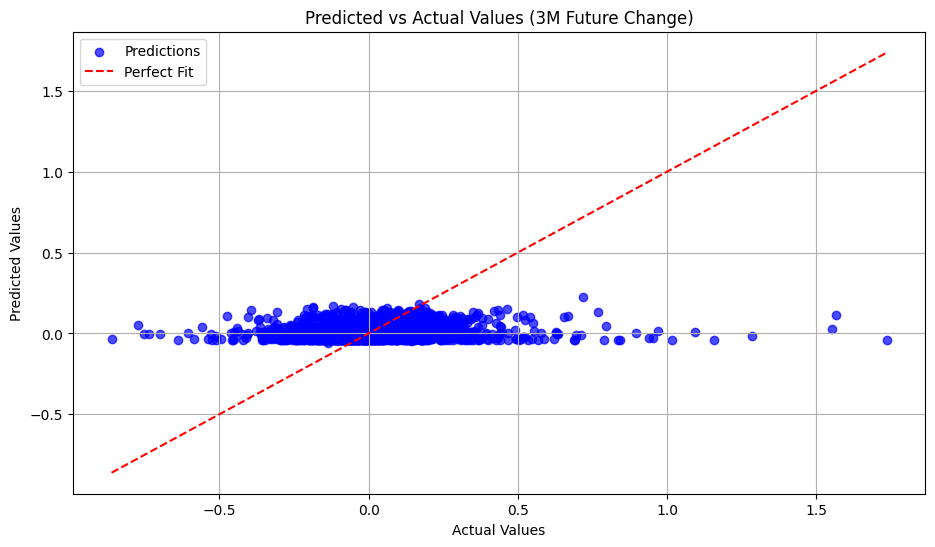

3M Future Change - R²: -0.0022
3M Future Change - MSE: 0.0429
3M Future Change - MAE: 0.1411


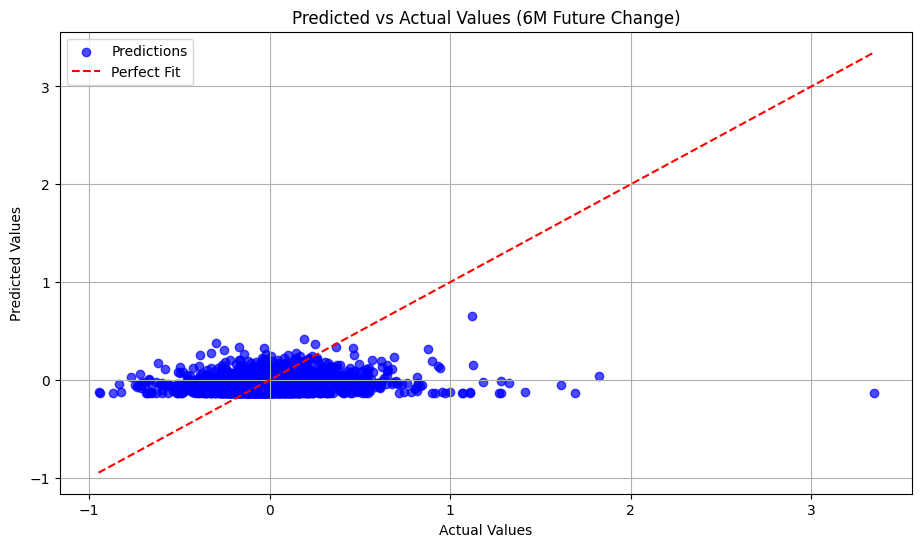

6M Future Change - R²: -0.0448
6M Future Change - MSE: 0.0861
6M Future Change - MAE: 0.1995


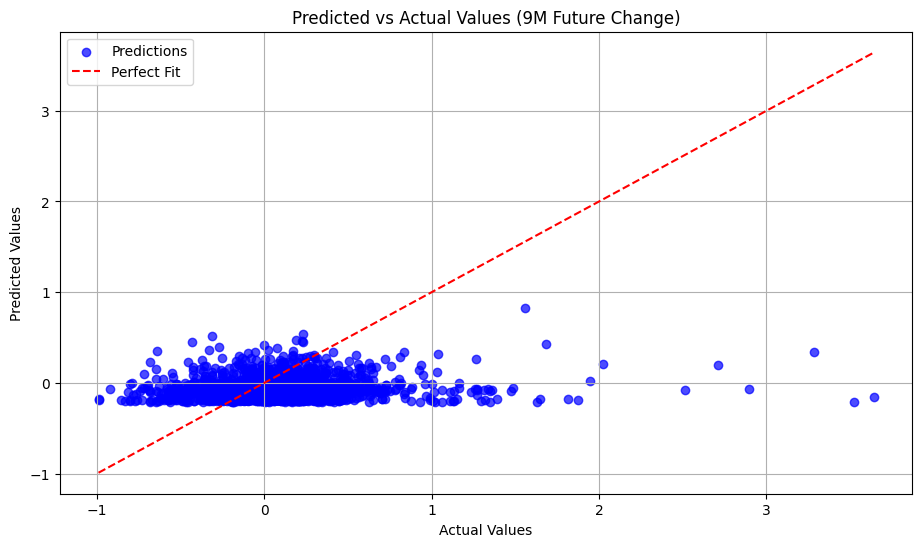

9M Future Change - R²: -0.2103
9M Future Change - MSE: 0.1786
9M Future Change - MAE: 0.2960


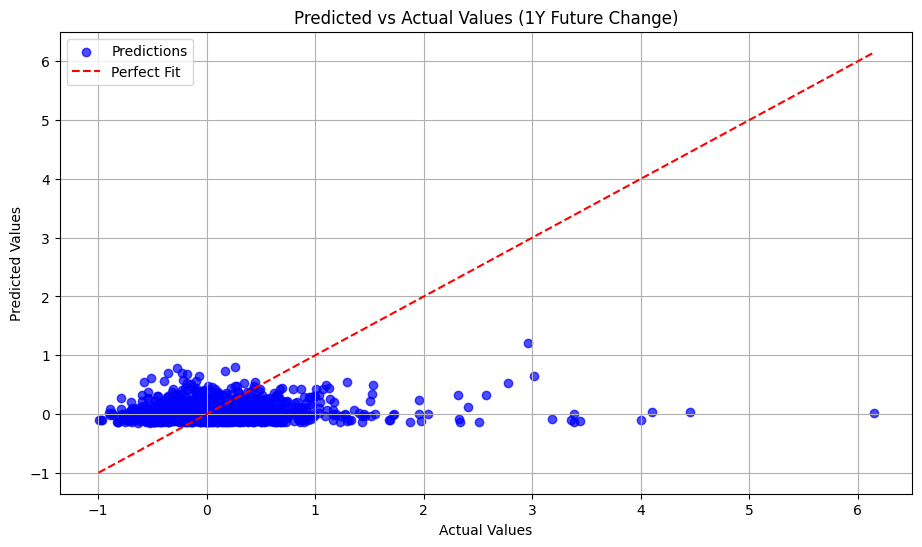

1Y Future Change - R²: -0.0736
1Y Future Change - MSE: 0.2776
1Y Future Change - MAE: 0.3435

Overall Scores:
Mean - R²: -0.0827
Mean - MSE: 0.1463
Mean - MAE: 0.2450


In [11]:
if train_new_model:
    y_test_pred = model.predict(X_test)

    for i, target in enumerate(['3M Future Change', '6M Future Change', '9M Future Change', '1Y Future Change']):
        y_test_actual = y_test[target]
        y_test_pred_target = y_test_pred[:, i]

        plt.figure(figsize=(11, 6))
        plt.scatter(y_test_actual, y_test_pred_target, alpha=0.7, color='blue', label='Predictions')
        plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 
            color='red', linestyle='--', label='Perfect Fit')
        plt.title(f'Predicted vs Actual Values ({target})')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.legend()
        plt.grid(True)
        plt.show()

        mae = mean_absolute_error(y_test_actual, y_test_pred_target)
        mse = mean_squared_error(y_test_actual, y_test_pred_target)
        r2 = r2_score(y_test_actual, y_test_pred_target)

        print(f'{target} - R²: {r2:.4f}')
        print(f'{target} - MSE: {mse:.4f}')
        print(f'{target} - MAE: {mae:.4f}')

    mae = mean_absolute_error(y_test, y_test_pred)
    mse = mean_squared_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)

    print('\nOverall Scores:')
    print(f'Mean - R²: {r2:.4f}')
    print(f'Mean - MSE: {mse:.4f}')
    print(f'Mean - MAE: {mae:.4f}')

### Log test results

In [12]:
if train_new_model:
    test_results = pd.DataFrame({
        'R²': r2,
        'MSE': mse,
        'MAE': mae,
        'symbol_list': symbol_list,
        'hidden_layer_sizes': [model.hidden_layer_sizes],
        'max_iter': model.max_iter,
        'n_iter_no_change': model.n_iter_no_change,
        'learning_rate': model.learning_rate,
        'learning_rate_init': model.learning_rate_init,
        'batch_size': model.batch_size,
        'tol': model.tol,
        'alpha': model.alpha,
        'shuffle': model.shuffle,
    })
    test_results.to_csv('../data/test_results.csv', mode='a', index=False)

    # save model as new best if results are better than the current one
    best_r2 = pd.read_csv('../models/best_model_results.csv').loc[0, 'R²']
    if r2 > best_r2:
        print(f'Old best R²: {best_r2}')
        print(f'New best R²: {r2}')
        print('Saving new best model...')
        test_results.to_csv('../models/best_model_results.csv', mode='w', index=False)
        with open('../models/best_model.pkl','wb') as f:
            pickle.dump(model,f)
        

## Predictions on latest data

In [13]:
best_r2 = pd.read_csv('../models/best_model_results.csv').loc[0, 'R²']

with open('../models/best_model.pkl', 'rb') as f:
    model = pickle.load(f)
    print(f'Best model R²: {best_r2}')


Best model R²: 0.0289336782535032


In [14]:
df_raw = pd.read_csv('../data/earnings_data.csv')

results = []
for i in range(len(X_pred)):
    y_pred = model.predict(X_pred.iloc[[i]])[0]
    y_pred_3m, y_pred_6m, y_pred_9m, y_pred_1y = y_pred
    avg = (y_pred_3m + y_pred_6m + y_pred_9m + y_pred_1y) / 4
    results.append({
        'Ticker': df_raw.loc[i*4, 'Ticker'],
        'Name': df_raw.loc[i*4, 'Name'],
        'mean (%)': avg * 100,
        '3m (%)': y_pred_3m * 100,
        '6m (%)': y_pred_6m * 100,
        '9m (%)': y_pred_9m * 100,
        '1y (%)': y_pred_1y * 100
    })

results_df = pd.DataFrame(results)
results_df

Ticker                            Name   mean (%)     3m (%)     6m (%)  \
0     RNMBY                  Rheinmetall AG   3.015727   2.648681  -0.093725   
1     SAABF                         Saab AB  10.647618   6.919716   6.728221   
2     NSKFF           Kongsberg Gruppen ASA  10.528074   6.808938   6.702207   
3      GMAB                      Genmab A/S  -1.553454  -0.564324  -4.873314   
4      NVDA              NVIDIA Corporation  15.186090  10.808454  10.354168   
...     ...                             ...        ...        ...        ...   
1891      Z              Zillow Group, Inc.  -2.015332  -0.900094  -5.471143   
1892   ZBRA  Zebra Technologies Corporation  -1.915944  -0.883366  -4.919541   
1893   ZEUS             Olympic Steel, Inc.  -1.186006  -0.308606  -4.395808   
1894   ZION       Zions Bancorporation N.A.  -5.069085  -3.362689  -9.544099   
1895   ZUMZ                     Zumiez Inc.   1.356634   1.486895  -1.396668   

         9m (%)     1y (%)  
0      0.742486   8.765466  
1      9.573324  19.369209  
2      9.350258  19.250894  
3     -3.880231   3.104053  
4     10.281970  29.299767  
...         ...        ...  
1891  -4.271451   2.581359  
1892  -4.234834   2.373965  
1893  -3.546415   3.506804  
1894  -6.625019  -0.744532  
1895  -1.107832   6.444140  

[1896 rows x 7 columns]

In [15]:
def predict_ticker(ticker_str):
    try:
        ticker_str = str(ticker_str).upper()
        ticker_str = ticker_str.replace("'", "")
        ticker_str = ticker_str.replace('"', "")
        row = results_df[results_df['Ticker'] == ticker_str]
        if row.empty:
            return (f"Not enough data for this stock at this moment \n Try another", "", "", "", "")
        row = row.iloc[0]
        return (
            f"{row['3m (%)']:.2f}",
            f"{row['6m (%)']:.2f}",
            f"{row['9m (%)']:.2f}",
            f"{row['1y (%)']:.2f}",
            f"{row['mean (%)']:.2f}",
        )
    except Exception as e:
        return (f"Error: {e}", "", "", "", "")

In [16]:
iface = gr.Interface(
    fn=predict_ticker,
    inputs=gr.Textbox(label="Ticker e.g. 'TSLA' or 'NVDA'"),
    outputs=[
        gr.Textbox(label="3 Month Change Prediction (%)"),
        gr.Textbox(label="6 Month Change Prediction (%)"),
        gr.Textbox(label="9 Month Change Prediction (%)"),
        gr.Textbox(label="1 Year Change Prediction (%)"),
        gr.Textbox(label="Mean Change Prediction (%)"),
    ],
    title="Stock Price Prediction Model",
    description=" "
)

iface.launch(share=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://5a07168d78b8f50975.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
